<a href="https://colab.research.google.com/github/devmcdonald/Fall-2023-NYU-AI/blob/main/VAE_Training_and_Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 17 – Autoencoders, GANs, and Diffusion Models**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [67]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [68]:
from packaging import version
import sklearn
import numpy as np

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [69]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [70]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/generative` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [71]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [72]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

Let's load the MNIST dataset, scale it, and split it into a training set, a validation set, and a test set:

In [75]:
# loads, scales, and splits the MNIST dataset
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Variational Autoencoder

In [76]:
import optuna

In [77]:
# Defines the VAE Model with mean and log_var as inputs to sampling probability
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [78]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 10

# Input size is 28 x 28 image
inputs = tf.keras.layers.Input(shape=[28, 28])
# Flatten input to 1D array
Z = tf.keras.layers.Flatten()(inputs)
# Add two fully connected dense layers to model
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
# Produce a mean and variance from encoder to generate probability distribution
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
# Sample from probability distribution generated with mean and variance above
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [79]:
# Standard decoder build: simple stack of layers to decode after sampling
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [80]:
# Can ignore first two outputs of encoder as we only need to feed codings to the decoder
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [81]:
# Add loss and optimizer to the model according to the mean and variance
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [82]:
variational_ae.compile(loss="mse", optimizer="nadam")

In [83]:
# Set initial latent_dims value
latent_dimensions = 10

In [84]:
# Optimize parameters (latent_dims and learning_rate) using Optuna
def objective(trial):
  global latent_dimensions
  # Build model same as above with these variables
  latent_dimensions = trial.suggest_int("latent_dim", 5, 20)
  _, _, codings = variational_encoder(inputs)
  reconstructions = variational_decoder(codings)
  variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

  # Compile model with learning_rate to be tested
  variational_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-2)))

  history = variational_ae.fit(X_train, X_train, epochs=10, batch_size=128,
                             validation_data=(X_valid, X_valid))
  return history.history["val_loss"][-1]

In [86]:
# Run 20 trials trying to minimize parameter values with low loss
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials=20)



[I 2023-12-20 22:58:25,187] A new study created in memory with name: no-name-454d78a3-e372-473e-ad3c-dccc89e767df


Epoch 1/10
430/430 [==============================] - 6s 7ms/step - loss: 0.0183 - val_loss: 0.0180
Epoch 2/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0180 - val_loss: 0.0180
Epoch 3/10
430/430 [==============================] - 3s 8ms/step - loss: 0.0180 - val_loss: 0.0181
Epoch 4/10
430/430 [==============================] - 3s 8ms/step - loss: 0.0180 - val_loss: 0.0179
Epoch 5/10
430/430 [==============================] - 4s 8ms/step - loss: 0.0179 - val_loss: 0.0180
Epoch 6/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0179 - val_loss: 0.0179
Epoch 7/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0179 - val_loss: 0.0181
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0179 - val_loss: 0.0181
Epoch 9/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0178 - val_loss: 0.0179
Epoch 10/10
430/430 [==============================] - 3s 7ms/step - loss: 0.0178 - val_loss: 0.0181

[I 2023-12-20 22:58:56,268] Trial 0 finished with value: 0.01805073954164982 and parameters: {'latent_dim': 16, 'learning_rate': 0.0050175695292566025}. Best is trial 0 with value: 0.01805073954164982.


Epoch 1/10
430/430 [==============================] - 6s 5ms/step - loss: 0.0200 - val_loss: 0.0193
Epoch 2/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0193 - val_loss: 0.0194
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0194 - val_loss: 0.0194
Epoch 4/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0194 - val_loss: 0.0196
Epoch 5/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0193 - val_loss: 0.0193
Epoch 6/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0194 - val_loss: 0.0196
Epoch 7/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0194 - val_loss: 0.0193
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0194 - val_loss: 0.0196
Epoch 9/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0194 - val_loss: 0.0196
Epoch 10/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0194 - val_loss: 0.0195

[I 2023-12-20 22:59:23,822] Trial 1 finished with value: 0.019481657072901726 and parameters: {'latent_dim': 5, 'learning_rate': 0.009738862517027729}. Best is trial 0 with value: 0.01805073954164982.


Epoch 1/10
430/430 [==============================] - 5s 5ms/step - loss: 0.0175 - val_loss: 0.0174
Epoch 2/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0173 - val_loss: 0.0173
Epoch 3/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0172 - val_loss: 0.0173
Epoch 4/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0172 - val_loss: 0.0173
Epoch 5/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 6/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0172
Epoch 7/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0171 - val_loss: 0.0172
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0172
Epoch 9/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 10/10
430/430 [==============================] - 2s 6ms/step - loss: 0.0170 - val_loss: 0.0172

[I 2023-12-20 23:00:07,310] Trial 2 finished with value: 0.017243528738617897 and parameters: {'latent_dim': 8, 'learning_rate': 0.0026387595044399447}. Best is trial 2 with value: 0.017243528738617897.


Epoch 1/10
430/430 [==============================] - 5s 7ms/step - loss: 0.0184 - val_loss: 0.0183
Epoch 2/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0181 - val_loss: 0.0181
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0181 - val_loss: 0.0185
Epoch 4/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0182 - val_loss: 0.0184
Epoch 5/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0181 - val_loss: 0.0182
Epoch 6/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0182 - val_loss: 0.0183
Epoch 7/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0182 - val_loss: 0.0180
Epoch 8/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0182 - val_loss: 0.0182
Epoch 9/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0181 - val_loss: 0.0182
Epoch 10/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0182 - val_loss: 0.0181

[I 2023-12-20 23:00:33,233] Trial 3 finished with value: 0.018146729096770287 and parameters: {'latent_dim': 9, 'learning_rate': 0.0065784741897501236}. Best is trial 2 with value: 0.017243528738617897.


Epoch 1/10
430/430 [==============================] - 4s 6ms/step - loss: 0.0174 - val_loss: 0.0175
Epoch 2/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0173 - val_loss: 0.0175
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0173 - val_loss: 0.0175
Epoch 4/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0173 - val_loss: 0.0175
Epoch 5/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0172 - val_loss: 0.0174
Epoch 6/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0172 - val_loss: 0.0174
Epoch 7/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0173 - val_loss: 0.0174
Epoch 8/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0172 - val_loss: 0.0174
Epoch 9/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0172 - val_loss: 0.0175
Epoch 10/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0172 - val_loss: 0.0175

[I 2023-12-20 23:01:16,027] Trial 4 finished with value: 0.017537733539938927 and parameters: {'latent_dim': 12, 'learning_rate': 0.0037090596341484753}. Best is trial 2 with value: 0.017243528738617897.


Epoch 1/10
430/430 [==============================] - 5s 5ms/step - loss: 0.0179 - val_loss: 0.0179
Epoch 2/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0178 - val_loss: 0.0180
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0178 - val_loss: 0.0180
Epoch 4/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0178 - val_loss: 0.0179
Epoch 5/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0178 - val_loss: 0.0180
Epoch 6/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0178 - val_loss: 0.0180
Epoch 7/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0178 - val_loss: 0.0180
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0179 - val_loss: 0.0181
Epoch 9/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0178 - val_loss: 0.0179
Epoch 10/10
430/430 [==============================] - 3s 7ms/step - loss: 0.0178 - val_loss: 0.0180

[I 2023-12-20 23:01:59,362] Trial 5 finished with value: 0.01801099255681038 and parameters: {'latent_dim': 19, 'learning_rate': 0.005744795403634237}. Best is trial 2 with value: 0.017243528738617897.


Epoch 1/10
430/430 [==============================] - 4s 5ms/step - loss: 0.0172 - val_loss: 0.0174
Epoch 2/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 3/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 4/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 5/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 6/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0175
Epoch 7/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0172
Epoch 9/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0171 - val_loss: 0.0174
Epoch 10/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0173

[I 2023-12-20 23:02:42,125] Trial 6 finished with value: 0.01733885332942009 and parameters: {'latent_dim': 12, 'learning_rate': 0.0034803513377348267}. Best is trial 2 with value: 0.017243528738617897.


Epoch 1/10
430/430 [==============================] - 5s 7ms/step - loss: 0.0168 - val_loss: 0.0171
Epoch 2/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0168 - val_loss: 0.0170
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0168 - val_loss: 0.0170
Epoch 4/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0168 - val_loss: 0.0170
Epoch 5/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0168 - val_loss: 0.0171
Epoch 6/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0168 - val_loss: 0.0171
Epoch 7/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0168 - val_loss: 0.0170
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0168 - val_loss: 0.0170
Epoch 9/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0168 - val_loss: 0.0170
Epoch 10/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0168 - val_loss: 0.0171

[I 2023-12-20 23:03:24,844] Trial 7 finished with value: 0.017107123509049416 and parameters: {'latent_dim': 13, 'learning_rate': 0.0025045577041578533}. Best is trial 7 with value: 0.017107123509049416.


Epoch 1/10
430/430 [==============================] - 4s 5ms/step - loss: 0.0168 - val_loss: 0.0171
Epoch 2/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0168 - val_loss: 0.0171
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0168 - val_loss: 0.0170
Epoch 4/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0168 - val_loss: 0.0171
Epoch 5/10
430/430 [==============================] - 2s 6ms/step - loss: 0.0168 - val_loss: 0.0171
Epoch 6/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0168 - val_loss: 0.0172
Epoch 7/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0168 - val_loss: 0.0171
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0168 - val_loss: 0.0170
Epoch 9/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0168 - val_loss: 0.0170
Epoch 10/10
430/430 [==============================] - 2s 6ms/step - loss: 0.0168 - val_loss: 0.0171

[I 2023-12-20 23:03:48,882] Trial 8 finished with value: 0.017099829390645027 and parameters: {'latent_dim': 6, 'learning_rate': 0.0026892816399240595}. Best is trial 8 with value: 0.017099829390645027.


Epoch 1/10
430/430 [==============================] - 4s 5ms/step - loss: 0.0165 - val_loss: 0.0168
Epoch 2/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0164 - val_loss: 0.0168
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0164 - val_loss: 0.0168
Epoch 4/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0164 - val_loss: 0.0167
Epoch 5/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0164 - val_loss: 0.0167
Epoch 6/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0164 - val_loss: 0.0168
Epoch 7/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0164 - val_loss: 0.0167
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0164 - val_loss: 0.0167
Epoch 9/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0164 - val_loss: 0.0167
Epoch 10/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0164 - val_loss: 0.0168

[I 2023-12-20 23:04:32,116] Trial 9 finished with value: 0.016781488433480263 and parameters: {'latent_dim': 9, 'learning_rate': 0.0015474322654223226}. Best is trial 9 with value: 0.016781488433480263.


Epoch 1/10
430/430 [==============================] - 4s 5ms/step - loss: 0.0163 - val_loss: 0.0168
Epoch 2/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0163 - val_loss: 0.0167
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0163 - val_loss: 0.0167
Epoch 4/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0163 - val_loss: 0.0166
Epoch 5/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0163 - val_loss: 0.0166
Epoch 6/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0163 - val_loss: 0.0166
Epoch 7/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0163 - val_loss: 0.0167
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0163 - val_loss: 0.0166
Epoch 9/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0163 - val_loss: 0.0166
Epoch 10/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0163 - val_loss: 0.0167

[I 2023-12-20 23:04:56,440] Trial 10 finished with value: 0.01667444035410881 and parameters: {'latent_dim': 9, 'learning_rate': 0.0011905300263025703}. Best is trial 10 with value: 0.01667444035410881.


Epoch 1/10
430/430 [==============================] - 4s 5ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 2/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 3/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 4/10
430/430 [==============================] - 2s 6ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 5/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 6/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 7/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 9/10
430/430 [==============================] - 2s 6ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 10/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0160 - val_loss: 0.0165

[I 2023-12-20 23:05:39,264] Trial 11 finished with value: 0.016479801386594772 and parameters: {'latent_dim': 9, 'learning_rate': 0.0004945415532831921}. Best is trial 11 with value: 0.016479801386594772.


Epoch 1/10
430/430 [==============================] - 5s 7ms/step - loss: 0.0161 - val_loss: 0.0166
Epoch 2/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 4/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 5/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 6/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 7/10
430/430 [==============================] - 2s 6ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 9/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 10/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0161 - val_loss: 0.0165

[I 2023-12-20 23:06:22,108] Trial 12 finished with value: 0.016520611941814423 and parameters: {'latent_dim': 10, 'learning_rate': 0.0006438222826776656}. Best is trial 11 with value: 0.016479801386594772.


Epoch 1/10
430/430 [==============================] - 4s 5ms/step - loss: 0.0160 - val_loss: 0.0164
Epoch 2/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0160 - val_loss: 0.0164
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 4/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0160 - val_loss: 0.0164
Epoch 5/10
430/430 [==============================] - 2s 6ms/step - loss: 0.0160 - val_loss: 0.0164
Epoch 6/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0160 - val_loss: 0.0164
Epoch 7/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0160 - val_loss: 0.0164
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0160 - val_loss: 0.0164
Epoch 9/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0160 - val_loss: 0.0164
Epoch 10/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0160 - val_loss: 0.0164

[I 2023-12-20 23:07:05,008] Trial 13 finished with value: 0.016429292038083076 and parameters: {'latent_dim': 15, 'learning_rate': 0.0002975857850245694}. Best is trial 13 with value: 0.016429292038083076.


Epoch 1/10
430/430 [==============================] - 5s 6ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 2/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 4/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 5/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 6/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 7/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 8/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 9/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 10/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0160 - val_loss: 0.0165

[I 2023-12-20 23:07:29,881] Trial 14 finished with value: 0.01647675596177578 and parameters: {'latent_dim': 16, 'learning_rate': 0.0005234846573862517}. Best is trial 13 with value: 0.016429292038083076.


Epoch 1/10
430/430 [==============================] - 4s 6ms/step - loss: 0.0188 - val_loss: 0.0183
Epoch 2/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0184 - val_loss: 0.0186
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0184 - val_loss: 0.0183
Epoch 4/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0183 - val_loss: 0.0185
Epoch 5/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0184 - val_loss: 0.0188
Epoch 6/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0185 - val_loss: 0.0189
Epoch 7/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0185 - val_loss: 0.0183
Epoch 8/10
430/430 [==============================] - 2s 6ms/step - loss: 0.0185 - val_loss: 0.0187
Epoch 9/10
430/430 [==============================] - 2s 6ms/step - loss: 0.0184 - val_loss: 0.0187
Epoch 10/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0185 - val_loss: 0.0186

[I 2023-12-20 23:08:12,812] Trial 15 finished with value: 0.01857076957821846 and parameters: {'latent_dim': 16, 'learning_rate': 0.008015809929719737}. Best is trial 13 with value: 0.016429292038083076.


Epoch 1/10
430/430 [==============================] - 5s 5ms/step - loss: 0.0166 - val_loss: 0.0167
Epoch 2/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0163 - val_loss: 0.0166
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0163 - val_loss: 0.0166
Epoch 4/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0162 - val_loss: 0.0166
Epoch 5/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0162 - val_loss: 0.0166
Epoch 6/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0162 - val_loss: 0.0165
Epoch 7/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0162 - val_loss: 0.0165
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0162 - val_loss: 0.0165
Epoch 9/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 10/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0165

[I 2023-12-20 23:08:56,323] Trial 16 finished with value: 0.01649787835776806 and parameters: {'latent_dim': 16, 'learning_rate': 0.000292893855466054}. Best is trial 13 with value: 0.016429292038083076.


Epoch 1/10
430/430 [==============================] - 4s 5ms/step - loss: 0.0166 - val_loss: 0.0169
Epoch 2/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0165 - val_loss: 0.0168
Epoch 3/10
430/430 [==============================] - 3s 7ms/step - loss: 0.0165 - val_loss: 0.0169
Epoch 4/10
430/430 [==============================] - 2s 6ms/step - loss: 0.0165 - val_loss: 0.0168
Epoch 5/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0165 - val_loss: 0.0168
Epoch 6/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0165 - val_loss: 0.0168
Epoch 7/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0165 - val_loss: 0.0168
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0165 - val_loss: 0.0168
Epoch 9/10
430/430 [==============================] - 2s 6ms/step - loss: 0.0165 - val_loss: 0.0168
Epoch 10/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0165 - val_loss: 0.0168

[I 2023-12-20 23:09:39,070] Trial 17 finished with value: 0.016821427270770073 and parameters: {'latent_dim': 19, 'learning_rate': 0.0017782766843547461}. Best is trial 13 with value: 0.016429292038083076.


Epoch 1/10
430/430 [==============================] - 5s 7ms/step - loss: 0.0171 - val_loss: 0.0174
Epoch 2/10
430/430 [==============================] - 2s 6ms/step - loss: 0.0171 - val_loss: 0.0175
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0174
Epoch 4/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0174
Epoch 5/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 6/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0174
Epoch 7/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0171 - val_loss: 0.0174
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 9/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 10/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 0.0174

[I 2023-12-20 23:10:22,207] Trial 18 finished with value: 0.017361566424369812 and parameters: {'latent_dim': 14, 'learning_rate': 0.004000536482260832}. Best is trial 13 with value: 0.016429292038083076.


Epoch 1/10
430/430 [==============================] - 4s 5ms/step - loss: 0.0184 - val_loss: 0.0183
Epoch 2/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0180 - val_loss: 0.0180
Epoch 3/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0181 - val_loss: 0.0185
Epoch 4/10
430/430 [==============================] - 2s 6ms/step - loss: 0.0181 - val_loss: 0.0184
Epoch 5/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0181 - val_loss: 0.0184
Epoch 6/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0181 - val_loss: 0.0183
Epoch 7/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0182 - val_loss: 0.0180
Epoch 8/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0182 - val_loss: 0.0185
Epoch 9/10
430/430 [==============================] - 2s 4ms/step - loss: 0.0181 - val_loss: 0.0183
Epoch 10/10
430/430 [==============================] - 2s 5ms/step - loss: 0.0181 - val_loss: 0.0184

[I 2023-12-20 23:10:46,157] Trial 19 finished with value: 0.01838039793074131 and parameters: {'latent_dim': 18, 'learning_rate': 0.007207566206217946}. Best is trial 13 with value: 0.016429292038083076.


In [87]:
# Print the best hyperparameters
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.number)
trial = study.best_trial
print('Value:', trial.value)
print('Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 20
Best trial: 13
Value: 0.016429292038083076
Params:
    latent_dim: 15
    learning_rate: 0.0002975857850245694


In [88]:
# Conduct final training of VAE model using tuned hyperparameter values from Optuna

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

variational_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=trial.params['learning_rate']))

history = variational_ae.fit(X_train, X_train, epochs=20, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/20
430/430 [==============================] - 4s 5ms/step - loss: 0.0164 - val_loss: 0.0166
Epoch 2/20
430/430 [==============================] - 3s 6ms/step - loss: 0.0162 - val_loss: 0.0165
Epoch 3/20
430/430 [==============================] - 2s 5ms/step - loss: 0.0162 - val_loss: 0.0165
Epoch 4/20
430/430 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 5/20
430/430 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 6/20
430/430 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 7/20
430/430 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 8/20
430/430 [==============================] - 3s 6ms/step - loss: 0.0161 - val_loss: 0.0164
Epoch 9/20
430/430 [==============================] - 2s 5ms/step - loss: 0.0160 - val_loss: 0.0164
Epoch 10/20
430/430 [==============================] - 2s 5ms/step - loss: 0.0160 - val_loss: 0.0164

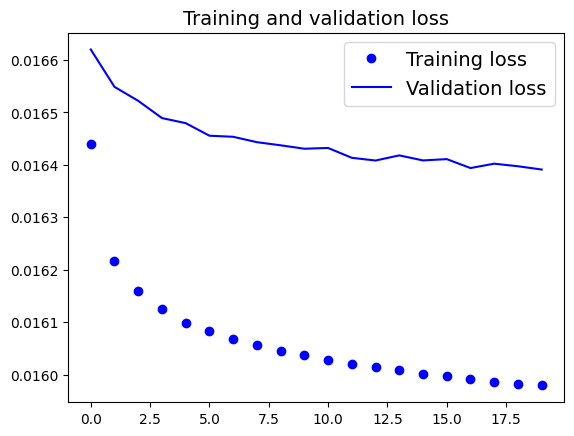

In [89]:
import matplotlib.pyplot as plt
# Plot training and validation loss from trained model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

# Decorate plot
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [90]:
from sklearn.manifold import TSNE

# Reduce dimensionality down to 2 using t-SNE algorithm for visualization
X_valid_compressed = variational_encoder.predict(X_valid)
X_valid_compressed = np.concatenate(X_valid_compressed, axis=0)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)



157/157 [==============================] - 0s 2ms/step


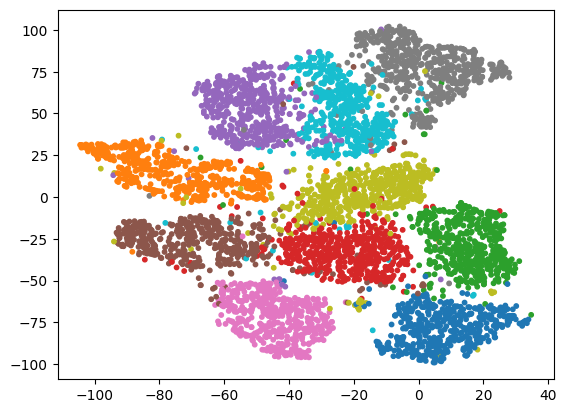

In [91]:

# Plot the dataset
plt.scatter(X_valid_2D[0:5000, 0], X_valid_2D[0:5000, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

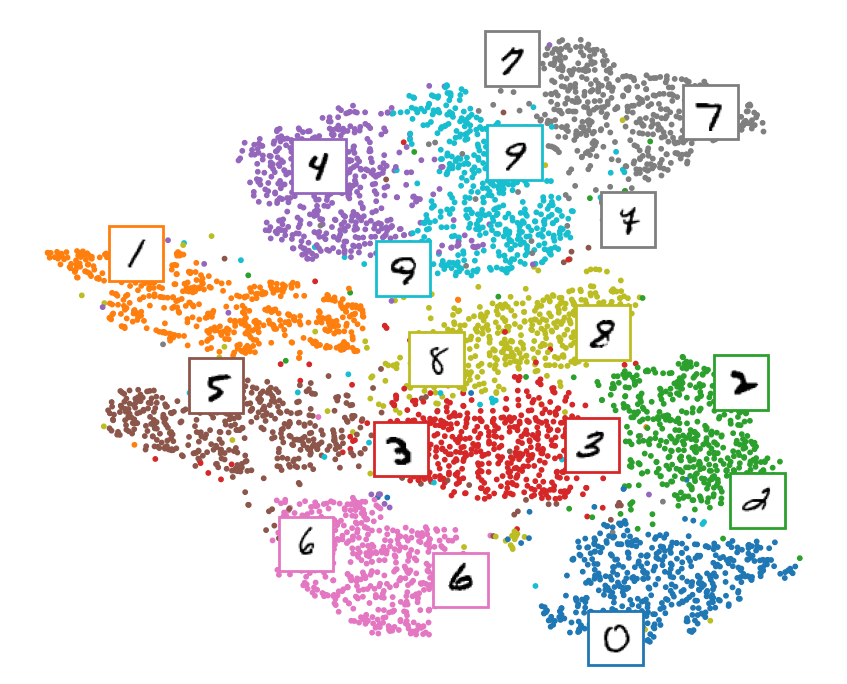

In [92]:
import matplotlib as mpl

# Clean up the plot above by adding in some of the images to their corresponding dots
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[0:5000, 0], Z[0:5000, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    if index >= 5000:
      break
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
save_fig("mnist_visualization_plot")
plt.show()

VAE generated images after model training

In [93]:
import numpy as np
# Plot reconstructions to verify that the autoencoder is trained properly. Inputs and outputs should be similar
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

1/1 [==============================] - 0s 132ms/step


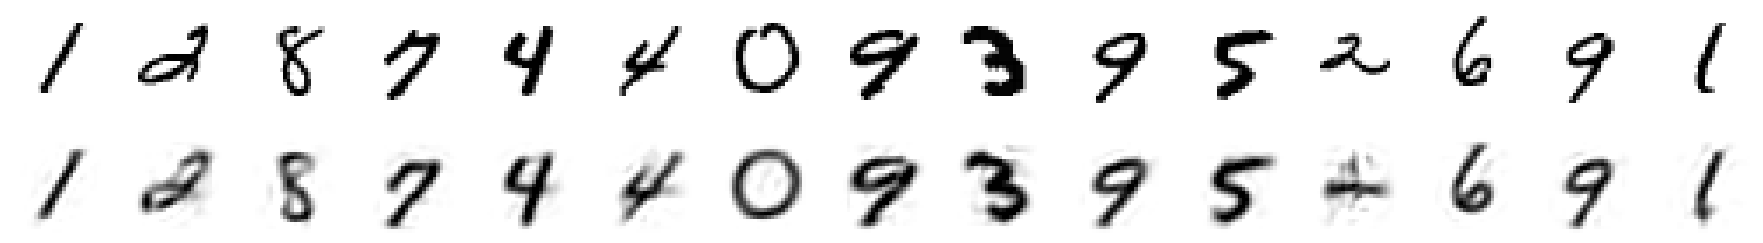

In [94]:

# Plot 15 images to make sure there is at least one of each digit 0-9 present
plot_reconstructions(variational_ae, n_images=15)
plt.show()